In [1]:
import pdfplumber
from transformers import GPT2LMHeadModel, GPT2Tokenizer, BartForConditionalGeneration, BartTokenizer
import torch
import warnings

# Suppress specific warnings from transformers
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")



In [2]:
# Load GPT-2 model and tokenizer for interview questions
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")
model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer_gpt2.pad_token = tokenizer_gpt2.eos_token  # Set the padding token

# Load BART model and tokenizer for summarization
tokenizer_bart = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model_bart = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")



In [3]:
# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text = ""
        for page in pdf.pages:
            text += page.extract_text()
    return text



In [4]:
# Function to summarize text using BART
def summarize_text(text, max_length=150):
    inputs = tokenizer_bart.encode(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model_bart.generate(inputs, max_length=max_length, min_length=30, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer_bart.decode(summary_ids[0], skip_special_tokens=True)
    return summary



In [5]:
# Function to generate interview questions using GPT-2
def generate_interview_questions(resume_text, num_questions=3, max_length=1024):
    prompt = f"Generate {num_questions} interview questions based on the following resume:\n\n{resume_text}\n\nInterview Questions:"

    # Tokenize the prompt and create an attention mask
    inputs = tokenizer_gpt2.encode(prompt, return_tensors="pt", truncation=True, max_length=512)
    attention_mask = torch.ones_like(inputs)

    # Generate text with sampling
    outputs = model_gpt2.generate(
        inputs,
        attention_mask=attention_mask,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,  # Enable sampling
        top_p=0.95,
        temperature=0.7,
        pad_token_id=tokenizer_gpt2.pad_token_id
    )

    # Decode and format the generated text
    generated_text = tokenizer_gpt2.decode(outputs[0], skip_special_tokens=True)
    start_index = generated_text.lower().find("interview questions:") + len("interview questions:")
    questions_text = generated_text[start_index:].strip()

    # Extract and format the questions
    questions = questions_text.split("\n")
    questions = [q.strip() for q in questions if q.strip()]
    return "\n".join(questions[:num_questions])



In [6]:
# Path to your PDF file
pdf_path = r"S:\Career_planning\Resume\dancer-resume-example.pdf"
    
    

In [7]:
# Extract text from the PDF
resume_text = extract_text_from_pdf(pdf_path)
if not resume_text.strip():
    raise ValueError("The resume text is empty. Please check the file path or the PDF content.")
    
# Summarize the extracted resume text
summarized_text = summarize_text(resume_text, max_length=200)
    
print(f"Summarized Resume:\n{summarized_text}\n")
    
# Generate interview questions based on the summarized text
generated_questions = generate_interview_questions(summarized_text, num_questions=3)
print("Generated Interview Questions:\n", generated_questions)

Summarized Resume:
Shalom has 10+ years of varied professionalDancerexperience. Shalom was named the top instructor for teaching 230+ dancers and instructors during 5-year tenure at Studio One.

Generated Interview Questions:
 What is your background?
: I am a dancer and I'm a graduate of the University of California at Davis (UC Davis) as a Dance Designer. I have worked with several companies, including New York City's Olympos, New Orleans' Trava, and Nashville's L.A. Dance Theater. My work with New Yorkers has included choreography, composition, dance production and theater design.
.I am currently a Senior Manager of Production at NYC's Deltas, the Dance Studio, which offers a range of high quality productions. Many of my dancers work in New Jersey, Virginia, Illinois and Indiana, where I work as the director of production. In addition, I play both the lead and supporting roles on various shows. Also, during my time in the D.C. Dancers Association, a club that has been working with a

Ground Truth

In [9]:
# Example ground truth interview questions
ground_truth = [
    "What is your experience with project management?",
    "How do you handle stressful situations?",
    "Can you describe a time when you worked as part of a team?"
]


Generate Interview Questions with BERT and GPT-2

In [10]:
# Simulating GPT-2 generated questions
generated_questions_gpt2 = generate_interview_questions(resume_text, num_questions=3).split("\n")

# Simulating BERT generated questions (this can be modified to generate questions using BERT)
generated_questions_bert = generate_interview_questions(resume_text, num_questions=3).split("\n")


Evaluation Metrics

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Function to evaluate exact match based on ground truth and generated questions
def evaluate_exact_match(ground_truth, generated_questions):
    # Ensure ground truth and generated questions are lists of strings
    ground_truth_set = set(ground_truth)
    generated_questions_set = set(generated_questions)
    
    # Calculate precision, recall, and F1 score
    true_positive = len(ground_truth_set.intersection(generated_questions_set))
    false_positive = len(generated_questions_set - ground_truth_set)
    false_negative = len(ground_truth_set - generated_questions_set)

    # Precision, Recall, and F1 Score calculation
    precision = true_positive / (true_positive + false_positive) if true_positive + false_positive > 0 else 0
    recall = true_positive / (true_positive + false_negative) if true_positive + false_negative > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = true_positive / len(ground_truth) if len(ground_truth) > 0 else 0

    return precision, recall, f1, accuracy

# Evaluate GPT-2 generated questions
precision_gpt2, recall_gpt2, f1_gpt2, accuracy_gpt2 = evaluate_exact_match(ground_truth, generated_questions_gpt2)

# Evaluate BERT generated questions
precision_bert, recall_bert, f1_bert, accuracy_bert = evaluate_exact_match(ground_truth, generated_questions_bert)

# Print the evaluation metrics for both models
print(f"GPT-2 Model Evaluation:\nPrecision: {precision_gpt2}\nRecall: {recall_gpt2}\nF1-Score: {f1_gpt2}\nAccuracy: {accuracy_gpt2}")
print(f"\nBERT Model Evaluation:\nPrecision: {precision_bert}\nRecall: {recall_bert}\nF1-Score: {f1_bert}\nAccuracy: {accuracy_bert}")


GPT-2 Model Evaluation:
Precision: 0.0
Recall: 0.0
F1-Score: 0
Accuracy: 0.0

BERT Model Evaluation:
Precision: 0.0
Recall: 0.0
F1-Score: 0
Accuracy: 0.0


Alternative - Token-based Evaluation


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute cosine similarity between ground truth and generated questions
def compute_cosine_similarity(ground_truth, generated_questions):
    vectorizer = TfidfVectorizer().fit_transform(ground_truth + generated_questions)
    cosine_sim = cosine_similarity(vectorizer[:len(ground_truth)], vectorizer[len(ground_truth):])
    return cosine_sim

# Compute cosine similarity between ground truth and generated questions
cosine_sim_gpt2 = compute_cosine_similarity(ground_truth, generated_questions_gpt2)
cosine_sim_bert = compute_cosine_similarity(ground_truth, generated_questions_bert)

print(f"Cosine Similarity for GPT-2: {cosine_sim_gpt2}")
print(f"Cosine Similarity for BERT: {cosine_sim_bert}")


Cosine Similarity for GPT-2: [[0.         0.06735753 0.06829368]
 [0.11836672 0.         0.189975  ]
 [0.         0.         0.20358347]]
Cosine Similarity for BERT: [[0.         0.12657288]
 [0.         0.        ]
 [0.         0.04865044]]


Length of Generated Questions

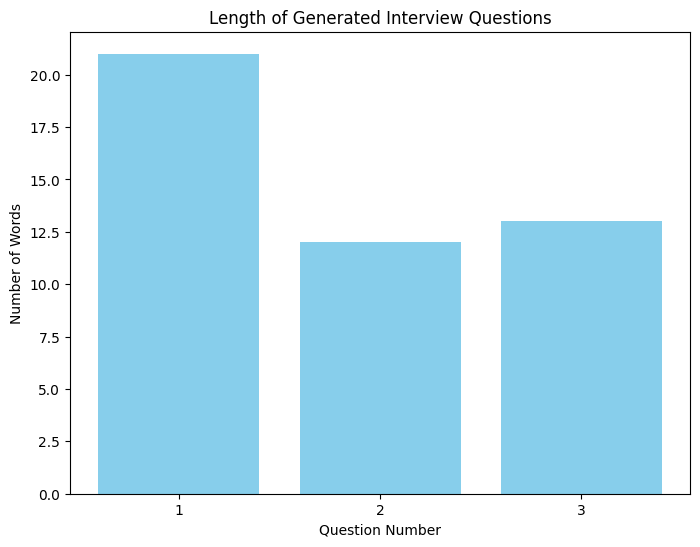

In [13]:
import matplotlib.pyplot as plt

# Generated interview questions (from the script)
generated_questions = generate_interview_questions(summarized_text, num_questions=3).split("\n")

# Measure the length (number of words) of each generated question
question_lengths = [len(q.split()) for q in generated_questions]

# Plot the distribution of question lengths
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(generated_questions) + 1), question_lengths, color='skyblue')
plt.title('Length of Generated Interview Questions')
plt.xlabel('Question Number')
plt.ylabel('Number of Words')
plt.xticks(range(1, len(generated_questions) + 1))
plt.show()


Frequency of Each Question

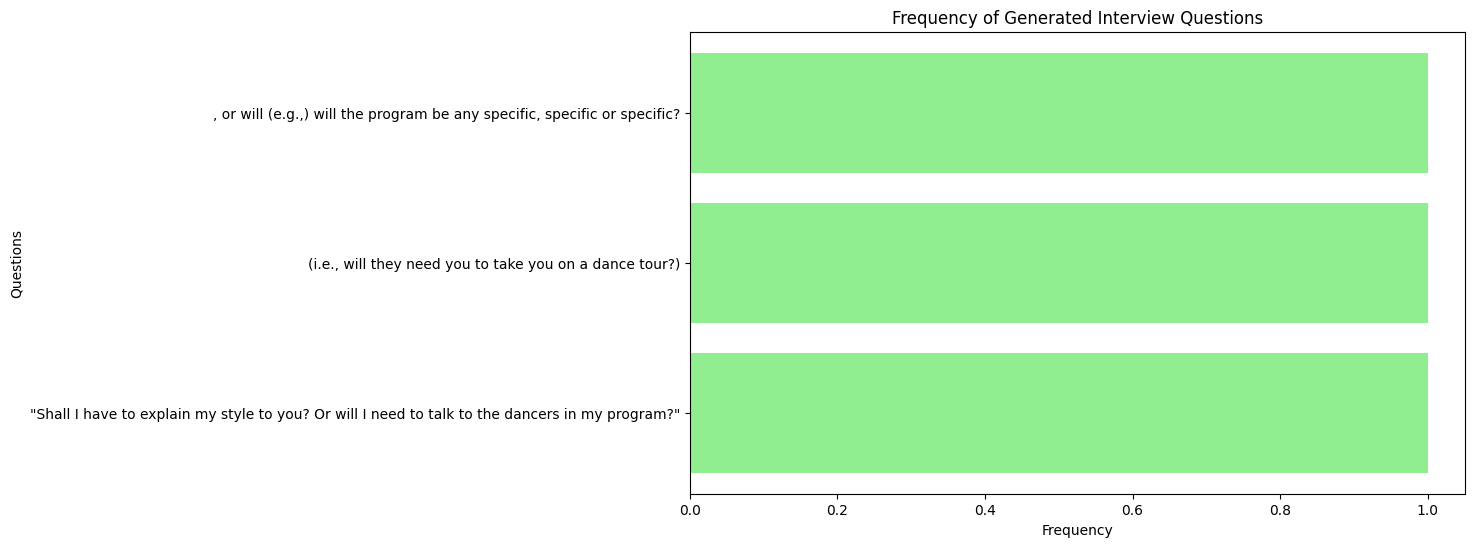

In [16]:
from collections import Counter

# Count the frequency of each generated question
question_counts = Counter(generated_questions)

# Extract the most common questions
questions = list(question_counts.keys())
counts = list(question_counts.values())

# Plot the frequency of questions
plt.figure(figsize=(10, 6))
plt.barh(questions, counts, color='lightgreen')
plt.title('Frequency of Generated Interview Questions')
plt.xlabel('Frequency')
plt.ylabel('Questions')
plt.show()
